<a href="https://colab.research.google.com/github/Lucas-Masaba/refactory-ml/blob/main/Part_I_Tabular_data_Maternal_risk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task: End-to-end prediction of maternal risk based on IoT monitoring data


### Dataset

Data was collected from different hospitals, community clinics, maternal health care centers in Bangladesh through an IoT based risk monitoring system.

- **Age**: Age in years when a woman is pregnant.

- **SystolicBP**: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- **DiastolicBP**: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- **BS**: Blood glucose levels is in terms of a molar concentration, mmol/L.
- **HeartRate**: A normal resting heart rate in beats per minute.

- **Risk Level**: Predicted Risk Intensity Level during pregnancy considering the previous attributes.

See https://www.kaggle.com/datasets/csafrit2/maternal-health-risk-data for details

**Questions**: Which health conditions are the strongest indications for health risks during pregnancy?




### Imports


Install some libraries. The rest of the libraries you need are installed for you already in the collab environment

In [3]:
!pip install pandas-profiling xgboost gradio


  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
Using cached joblib-1.1.1-py2.py3-none-any.whl (309 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.3.2
    Uninstalling joblib-1.3.2:
      Successfully uninstalled joblib-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.4.1.post1 requires joblib>=1.2.0, but you have joblib 1.1.1 which is incompatible.


In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import joblib


ModuleNotFoundError: No module named 'distutils'

### Data
First upload the data into the notebook.
The data can be found in the session repo: https://github.com/andrewkatumba/hash_aihealthcare_2023 in the tabular folder

### Now load the data and do a quick check on the first few rows

In [ ]:
!wget https://raw.githubusercontent.com/Marconi-Lab/giz_ml_2024/main/tabular/Maternal%20Health%20Risk%20Data%20Set.csv

--2024-03-09 13:39:37--  https://raw.githubusercontent.com/Marconi-Lab/giz_ml_2024/main/tabular/Maternal%20Health%20Risk%20Data%20Set.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30290 (30K) [text/plain]
Saving to: ‘Maternal Health Risk Data Set.csv.5’

Maternal Health Ris 100%[===================>]  29.58K  --.-KB/s    in 0.002s  

2024-03-09 13:39:37 (12.4 MB/s) - ‘Maternal Health Risk Data Set.csv.5’ saved [30290/30290]



In [ ]:
df = pd.read_csv('Maternal Health Risk Data Set.csv')
df.head()

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk

Now also check the last few rows

In [ ]:
df = pd.read_csv('Maternal Health Risk Data Set.csv')
df.tail()

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
1009   22         120           60  15.0      98.0         80  high risk
1010   55         120           90  18.0      98.0         60  high risk
1011   35          85           60  19.0      98.0         86  high risk
1012   43         120           90  18.0      98.0         70  high risk
1013   32         120           65   6.0     101.0         76   mid risk



```
# This is formatted as code
```



**EDA**

In [ ]:
df.dtypes


Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [ ]:
df.shape


(1014, 7)

In [ ]:
## null values
df.isnull().sum()


Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [ ]:
#Duplicated value
data_dup = df.duplicated().any()
data_dup

True

**Exercise 1:** Can you identify the rows with duplicate values? How many are they?

In [ ]:
number_of_duplicates = df.duplicated().sum()
number_of_duplicates

562

In [ ]:
df = df.drop_duplicates()


**Exercise 2:** Verify that any duplicates have been squashed

In [ ]:
number_of_duplicates = df.duplicated().sum()
number_of_duplicates

0

In [ ]:
data_dup = df.duplicated().any()
data_dup

False

## No-code EDA - the Pandas profiling package

In [ ]:
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Exercise 3:** Generate the pandas profiling report and answer the following


1.   Comment about the collinearity of the columns in the dataset above. Identify the columns with high correlations
2.   Regenerate the report with the initial dataset (including duplicates). Can you identify the missing values from this report? Are they the same as what you found earlier?
3.   Explain your intuition for the interactions view? Use any two highly correlated columns and any 2 columns with low correlation for your explanation.
4. Comment on the data-type for the risk value field. Is this what you expect?




1. The dataset exhibits collinearity between several pairs of columns. Collinearity refers to the linear relationship between two predictor variables. In this case, the columns "DiastolicBP" and "SystolicBP" exhibit high correlation which is also a common observation in blood pressure data.


2. From the regenerated report with the initial dataset (including duplicates), it appears that there are no missing values. This matches the previous finding, indicating that the missing values are consistent across different versions of the dataset.

3. Considering the two highly correlated columns "DiastolicBP" and "SystolicBP," we can observe how changes in one variable affect the other. This is helpful in understanding physiological relationships, especially in the context of blood pressure monitoring. On the other hand, considering two columns with low correlation, such as "Age" and "BodyTemp," the interactions view reveals minimal influence or relationship between them. This helps in identifying independent factors within the dataset.

4. The risk value field, which is categorical, has three distinct values: "low risk," "high risk," and "mid risk." This data type seems appropriate for representing the level of risk associated with each observation. Categorical data types are commonly used for variables with a finite set of discrete values, making it suitable for representing risk levels..

Map risk value to numerical values

In [ ]:
RiskLevel = {'low risk':0,
        'mid risk':1,
        'high risk':2}

# apply using map
df['RiskLevel'] = df['RiskLevel'].map(RiskLevel).astype(int)
df

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0     25         130           80  15.0      98.0         86          2
1     35         140           90  13.0      98.0         70          2
2     29          90           70   8.0     100.0         80          2
3     30         140           85   7.0      98.0         70          2
4     35         120           60   6.1      98.0         76          0
..   ...         ...          ...   ...       ...        ...        ...
673   12         100           50   6.4      98.0         70          1
674   15         100           60   6.0      98.0         80          0
703   15         100           49   7.6      98.0         77          0
704   12         100           50   6.0      98.0         70          1
705   21         100           50   6.8      98.0         60          0

[452 rows x 7 columns]

In [ ]:
df['RiskLevel'].value_counts()


0    234
2    112
1    106
Name: RiskLevel, dtype: int64

In [ ]:
df.describe()


Age  SystolicBP  DiastolicBP          BS    BodyTemp  \
count  452.000000  452.000000   452.000000  452.000000  452.000000   
mean    29.194690  110.553097    75.418142    8.346173   98.692478   
std     13.767379   17.872282    13.754578    2.829209    1.410897   
min     10.000000   70.000000    49.000000    6.000000   98.000000   
25%     19.000000   90.000000    65.000000    6.900000   98.000000   
50%     25.000000  120.000000    80.000000    7.500000   98.000000   
75%     35.000000  120.000000    86.000000    7.900000   98.000000   
max     70.000000  160.000000   100.000000   19.000000  103.000000   

        HeartRate   RiskLevel  
count  452.000000  452.000000  
mean    73.949115    0.730088  
std      8.156973    0.833169  
min      7.000000    0.000000  
25%     70.000000    0.000000  
50%     76.000000    0.000000  
75%     80.000000    1.000000  
max     90.000000    2.000000

In [ ]:
df.tail()

Age  SystolicBP  DiastolicBP   BS  BodyTemp  HeartRate  RiskLevel
673   12         100           50  6.4      98.0         70          1
674   15         100           60  6.0      98.0         80          0
703   15         100           49  7.6      98.0         77          0
704   12         100           50  6.0      98.0         70          1
705   21         100           50  6.8      98.0         60          0

In [ ]:
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Exercise 4:** From this new profile report? What do you think are the top 3 features that predict the risk level?

1. SystolicBP has the highest correlation with the risk level among all variables, indicating a significant influence on predicting risk.
2. DiastolicBP also shows a considerable correlation with the risk level, suggesting its importance in predicting risk.
3. Age has a slightly lower correlation compared to SystolicBP and DiastolicBP, age still exhibits a notable relationship with the risk level, making it a relevant predictor.

<Axes: xlabel='RiskLevel', ylabel='count'>

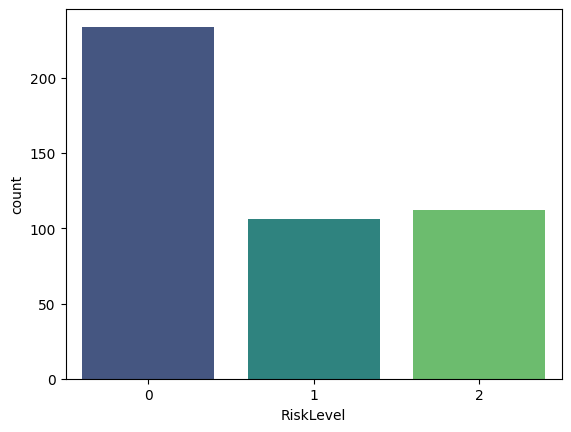

In [ ]:
sns.countplot(x='RiskLevel', data=df, palette='viridis')


**Bonus Exercise**: Play around with AI features for EDA in google collab. How do they compare to the profiling report above?


## Create the ML dataset

Separate the features from the labels in preparation for splitting and model training

In [ ]:
X = df.drop('RiskLevel',axis=1)
y = df['RiskLevel']

In [ ]:
X

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate
0     25         130           80  15.0      98.0         86
1     35         140           90  13.0      98.0         70
2     29          90           70   8.0     100.0         80
3     30         140           85   7.0      98.0         70
4     35         120           60   6.1      98.0         76
..   ...         ...          ...   ...       ...        ...
673   12         100           50   6.4      98.0         70
674   15         100           60   6.0      98.0         80
703   15         100           49   7.6      98.0         77
704   12         100           50   6.0      98.0         70
705   21         100           50   6.8      98.0         60

[452 rows x 6 columns]

In [ ]:
y

0      2
1      2
2      2
3      2
4      0
      ..
673    1
674    0
703    0
704    1
705    0
Name: RiskLevel, Length: 452, dtype: int64

#Split The Dataset into training and test sets


In [ ]:

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,
                                               random_state=42)
y_test

425    2
39     0
492    1
484    0
192    2
      ..
29     0
171    2
377    0
26     0
7      2
Name: RiskLevel, Length: 136, dtype: int64

In [ ]:
print(f'Training Shape x:',X_train.shape)
print(f'Testing Shape x:',X_test.shape)
print('*****___________*****___________*****')
print(f'Training Shape y:',X.shape)
print(f'Testing Shape y:',y.shape)

Training Shape x: (316, 6)
Testing Shape x: (136, 6)
*****___________*****___________*****
Training Shape y: (452, 6)
Testing Shape y: (452,)


### Normalize features for better convergence

In [ ]:
X_test

Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate
425   35         100           60  15.0      98.0         80
39    35         100           70   6.1      98.0         66
492   29         130           70   7.9      98.0         78
484   19         120           85   7.9      98.0         60
192   28          83           60   8.0     101.0         86
..   ...         ...          ...   ...       ...        ...
29    28          90           60   7.2      98.0         82
171   12          90           60   7.9     102.0         66
377   45         120           95   7.8      98.0         66
26    19         120           75   7.2      98.0         66
7     35          85           60  11.0     102.0         86

[136 rows x 6 columns]

In [ ]:
#StandardScaler

ss = StandardScaler()

X_train = ss.fit_transform(X_train)

X_test= ss.transform(X_test)

In [ ]:
X_test

array([[ 3.68796790e-01, -5.51939612e-01, -1.08458205e+00,
         2.33625064e+00, -5.06766862e-01,  7.30074598e-01],
       [ 3.68796790e-01, -5.51939612e-01, -3.59845472e-01,
        -7.99473675e-01, -5.06766862e-01, -9.14451890e-01],
       [-4.71691313e-02,  1.10755532e+00, -3.59845472e-01,
        -1.65282240e-01, -5.06766862e-01,  4.95142243e-01],
       [-7.40445666e-01,  5.54390343e-01,  7.27259396e-01,
        -1.65282240e-01, -5.06766862e-01, -1.61924896e+00],
       [-1.16496785e-01, -1.49232007e+00, -1.08458205e+00,
        -1.30049383e-01,  1.54103785e+00,  1.43487166e+00],
       [-6.01790359e-01, -1.93485206e+00, -1.80931863e+00,
        -2.35747955e-01, -5.06766862e-01, -1.61924896e+00],
       [ 2.10198813e+00,  1.66072030e+00,  1.08962768e+00,
         1.27926492e+00, -5.06766862e-01,  3.77676065e-01],
       [-4.63135052e-01,  1.66072030e+00,  1.08962768e+00,
        -5.52843673e-01, -5.06766862e-01, -4.44587179e-01],
       [-6.71118013e-01, -5.51939612e-01,  1.089



```
# This is formatted as code
```

**Exercise 5:** By examining the X_test dataframe before and after normalization, explain the impact of the StandardScaler above

**Before Normalization**:
The original data in X_test had different scales for its features including a different range, mean, and standard deviation. This might have given more weight to features with larger scales, potentially biasing the learning process.

**After Normalization**:
By applying StandardScaler, the data is transformed such that each feature now has a mean of 0 and a standard deviation of 1. The transformation centers the data around zero and scales it so that it has a consistent standard deviation. This ensures that all features contribute equally to the model fitting process and prevents features with larger scales from dominating the learning process. The transformed X_test now has standardized features, making it more suitable for models that assume the data is normally distributed and have similar scales across features. The impact of the StandardScaler is that the model will likely perform better, as it can learn more effectively from the standardized features and make more accurate predictions.

### Train the Support Vector Classifier model

In [ ]:
#Applying SVC (Support Vector Classification)
from sklearn.svm import SVC

#Create svm
svm = SVC(kernel='rbf', random_state=0, gamma=.10, C=1.0)
svm.fit(X_train, y_train)
print("Train accuracy:",svm.score(X_train,y_train))
print("Test accuracy:",svm.score(X_test,y_test))

y_pred = svm.predict(X_test)
print(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f'CM:',cm)
print(f'Accuracy:',accuracy_score(y_test, y_pred)* 100 ,'%')
print(classification_report(y_test, svm.predict(X_test)))

Train accuracy: 0.7246835443037974
Test accuracy: 0.6544117647058824
[2 0 0 0 2 0 2 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 2 0 0 2 0 2 0 0 0
 0 2 0 0 1 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 2 1 0 0
 2 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 2 2 0 2 0 0 2 2 0 0 2 0 0
 0 0 2 0 0 2 2 0 1 0 1 0 0 0 0 2 0 2 0 0 0 2 0 0 2]
CM: [[62  2  1]
 [30  2  7]
 [ 6  1 25]]
Accuracy: 65.44117647058823 %
              precision    recall  f1-score   support

           0       0.63      0.95      0.76        65
           1       0.40      0.05      0.09        39
           2       0.76      0.78      0.77        32

    accuracy                           0.65       136
   macro avg       0.60      0.60      0.54       136
weighted avg       0.60      0.65      0.57       136



### Train the XGBoost model

In [ ]:
#Applying XGBoost
import xgboost as xgb

#Create XGBClassifier
xgb_clf = xgb.XGBClassifier()

xgb_clf = xgb_clf.fit(X_train, y_train)

print("Train accuracy:",xgb_clf.score(X_train,y_train))
print("Test accuracy:",xgb_clf.score(X_test,y_test))

y_pred = xgb_clf.predict(X_test)
print(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f'CM:',cm)
print(f'Accuracy:',accuracy_score(y_test, y_pred)* 100 ,'%')
print(classification_report(y_test, xgb_clf.predict(X_test)))

Train accuracy: 0.9430379746835443
Test accuracy: 0.6544117647058824
[2 0 1 1 1 0 2 2 0 0 2 2 0 0 0 0 0 0 0 0 0 2 0 2 1 0 0 0 1 0 0 0 0 0 0 0 0
 1 2 0 0 2 0 1 0 2 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 1 0 0 0 1 2 2 0 1
 2 0 0 0 0 2 2 1 1 0 0 0 0 0 0 0 1 0 2 2 1 1 0 0 2 0 1 2 1 0 2 0 0 0 2 1 2
 0 2 2 0 0 2 2 0 1 2 1 0 0 0 0 2 0 2 0 0 0 2 0 0 2]
CM: [[54  9  2]
 [23 10  6]
 [ 4  3 25]]
Accuracy: 65.44117647058823 %
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        65
           1       0.45      0.26      0.33        39
           2       0.76      0.78      0.77        32

    accuracy                           0.65       136
   macro avg       0.63      0.62      0.61       136
weighted avg       0.63      0.65      0.63       136



### Train the Decision Tree model


In [ ]:
#Applying Decision Tree
from sklearn import tree

#Create tree object
decision_tree = tree.DecisionTreeClassifier(criterion='gini')

#Train DT based on scaled training set
decision_tree.fit(X_train, y_train)

print("Train accuracy:",decision_tree.score(X_train,y_train))
print("Test accuracy:",decision_tree.score(X_test,y_test))

y_pred = decision_tree.predict(X_test)
print(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f'CM:',cm)
print(f'Accuracy:',accuracy_score(y_test, y_pred)* 100 ,'%')
print(classification_report(y_test, decision_tree.predict(X_test)))

Train accuracy: 0.9430379746835443
Test accuracy: 0.6544117647058824
[2 0 1 1 1 0 2 2 0 0 2 2 0 0 0 0 0 0 0 0 0 1 0 2 2 0 2 0 1 0 0 0 0 0 0 1 0
 1 1 0 1 1 0 1 0 2 1 2 1 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 0 1 2 2 0 1
 2 0 0 0 0 2 1 1 1 0 0 0 1 0 0 0 0 0 2 2 0 1 0 0 2 0 1 1 1 0 1 2 1 0 2 1 2
 0 1 0 0 0 2 2 0 1 2 1 0 0 0 0 2 0 2 1 0 0 0 0 0 2]
CM: [[55  8  2]
 [20 14  5]
 [ 3  9 20]]
Accuracy: 65.44117647058823 %
              precision    recall  f1-score   support

           0       0.71      0.85      0.77        65
           1       0.45      0.36      0.40        39
           2       0.74      0.62      0.68        32

    accuracy                           0.65       136
   macro avg       0.63      0.61      0.62       136
weighted avg       0.64      0.65      0.64       136



### Train the RandomForest classifier

In [ ]:
#Applying RandomForest
from sklearn.ensemble import RandomForestClassifier

#Create Random Forest object
random_forest = RandomForestClassifier()

#Train model
random_forest.fit(X_train, y_train)

print("Train accuracy:",random_forest.score(X_train,y_train))
print("Test accuracy:",random_forest.score(X_test,y_test))

y_pred = random_forest.predict(X_test)
print(y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f'CM:',cm)
print(f'Accuracy:',accuracy_score(y_test, y_pred)* 100 ,'%')
print(classification_report(y_test, random_forest.predict(X_test)))

Train accuracy: 0.9430379746835443
Test accuracy: 0.6544117647058824
[2 0 1 1 1 0 2 2 0 0 2 2 0 0 0 0 0 0 0 0 0 1 0 2 2 0 0 0 1 0 0 0 0 1 0 0 0
 1 2 0 0 1 0 1 0 2 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 1 2 2 0 1
 2 0 0 0 0 2 2 1 1 0 0 0 0 0 0 0 1 0 2 2 1 1 1 0 2 0 1 2 1 0 2 0 0 0 2 1 1
 0 2 2 0 0 2 2 0 1 2 1 0 0 0 0 2 0 2 0 0 0 2 0 0 2]
CM: [[54  9  2]
 [23 11  5]
 [ 3  5 24]]
Accuracy: 65.44117647058823 %
              precision    recall  f1-score   support

           0       0.68      0.83      0.74        65
           1       0.44      0.28      0.34        39
           2       0.77      0.75      0.76        32

    accuracy                           0.65       136
   macro avg       0.63      0.62      0.62       136
weighted avg       0.63      0.65      0.63       136



**Exercise 6:** Which of the models above has the best performance? Explain your reasoning.

**Exercise 7**: What does a big difference between the train and tesrt data imply?

**Exercise 6**:
Among the models evaluated, the RandomForest model has the best performance based on the test accuracy of approximately 66.18%, which is slightly higher than the other models. Additionally, RandomForest has relatively balanced precision, recall, and F1-score across all classes, indicating good overall performance in classification.

**Exercise 7**:
A big difference between the train and test data implies overfitting which occurs when a model learns to memorize the training data rather than generalize patterns from it. A large disparity between train and test accuracy suggests that the model is fitting too closely to the training data, capturing noise and outliers rather than underlying patterns. In practical terms, an overfitted model may perform exceptionally well on the training data but poorly on unseen data, leading to poor generalization and potential failure to perform well in real-world scenarios.

Save your best model using the code below for later use reload model for inference

In [ ]:
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(random_forest, filename)


['finalized_model.sav']

In [ ]:
# load the model from disk
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.6544117647058824


**Exercise 8:** Check if you can   improve the performance of your best model further. Look at https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
Hint: Some target parameters to change include n_estimators, criterion

**Exercise 9**: In the section on splitting the dataset above, we selected a test dataset size of 30% (test_size=0.3). Try different values for this such as 5%, 10%, 20%, 40%. What is the impact of the size of the test performance on the model? What is the optimal split.
Do this for only the best model.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score


# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate the grid search
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1_macro')

# Perform grid search
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model
train_accuracy = best_rf_model.score(X_train, y_train)
test_accuracy = best_rf_model.score(X_test, y_test)
y_pred = best_rf_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')

print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)
print("F1-score:", f1)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(f'Accuracy:',accuracy_score(y_test, y_pred)* 100 ,'%')
print("Classification report:\n", classification_report(y_test, y_pred))

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Train accuracy: 0.8670886075949367
Test accuracy: 0.6911764705882353
F1-score: 0.6331310301898537
Confusion matrix:
 [[60  4  1]
 [25  9  5]
 [ 3  4 25]]
Accuracy: 69.11764705882352 %
Classification report:
               precision    recall  f1-score   support

           0       0.68      0.92      0.78        65
           1       0.53      0.23      0.32        39
           2       0.81      0.78      0.79        32

    accuracy                           0.69       136
   macro avg       0.67      0.65      0.63       136
weighted avg       0.67      0.69      0.65       136



By using hyperparemeter tuning, we can see that the test and train data is closer to each other than before to decrease on the risk of overfitting. The accuracy has also improved as a result.

In [ ]:
from sklearn.model_selection import train_test_split

# Define test sizes excluding the 0.3 used earlier
test_sizes = [0.05, 0.1, 0.2, 0.4]

# List to store results
results = []

for size in test_sizes:
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)

    # Train the model
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train, y_train)

    # Evaluate the model
    train_accuracy = random_forest.score(X_train, y_train)
    test_accuracy = random_forest.score(X_test, y_test)

    results.append((size, train_accuracy, test_accuracy))

# Print results limiting to 4 decimal places
print("Test Size\tTrain Accuracy\tTest Accuracy")
for size, train_acc, test_acc in results:
    print(f"{size}\t\t{train_acc:.4f}\t\t{test_acc:.4f}")


Test Size	Train Accuracy	Test Accuracy
0.05		0.9231		0.6087
0.1		0.9261		0.5870
0.2		0.9335		0.6703
0.4		0.9520		0.6464


As the test dataset size increases, the test accuracy tends to fluctuate. A test dataset size of 20% yields the highest test accuracy of 0.6703.
The optimal split size appears to be around 20%, as it provides a good balance between train and test accuracy, indicating better generalization performance compared to other test sizes hence reducing on the risk of over fitting.

## Feature importances for Random Forest Classifier

Text(0.5, 0, 'Random Forest Feature Importance')

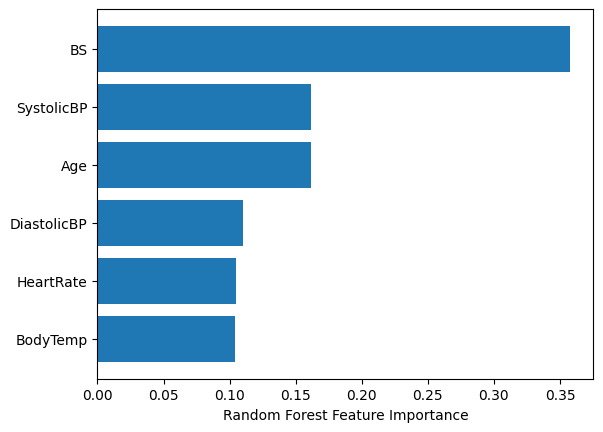

In [ ]:
rf = random_forest
rf.feature_importances_
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

 Deploy the model into an inference UI

In [ ]:
def get_key(val):

    for key, value in RiskLevel.items():
        if val == value:
            return key

    return "key doesn't exist"

In [ ]:
get_key(2)

'high risk'

In [ ]:
def predict_single(Age=25,	SystolicBP=130, DiastolicBP=80,	BS=15.,	BodyTemp=98.,	HeartRate=86):
  input = np.array([Age,	SystolicBP,	DiastolicBP,	BS,	BodyTemp,	HeartRate])#.reshape(-1,1)
  print(input.shape)
  res = ss.transform(input.reshape(1, -1))
  ans_1 = rf.predict(res)
  return get_key(ans_1[0])

In [ ]:
predict_single()

(6,)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


'mid risk'

In [ ]:
import gradio as gr

def predict(Age,	SystolicBP,	DiastolicBP,	BS,	BodyTemp,	HeartRate):
    output = predict_single(Age,	SystolicBP,	DiastolicBP,	BS,
                              BodyTemp,	HeartRate)

    return output

demo = gr.Interface(
    fn=predict,
    inputs=["number", "number", "number", "number", "number", "number"],
    outputs="text"
)
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://31fbe73e46b3c7fcbd.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
